In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score

In [3]:
df=pd.read_parquet('husky_data.parquet')
maquinas=list(df["asset"].unique())
maquinas.reverse()
maquinas.append('Error')
maquinas.reverse()

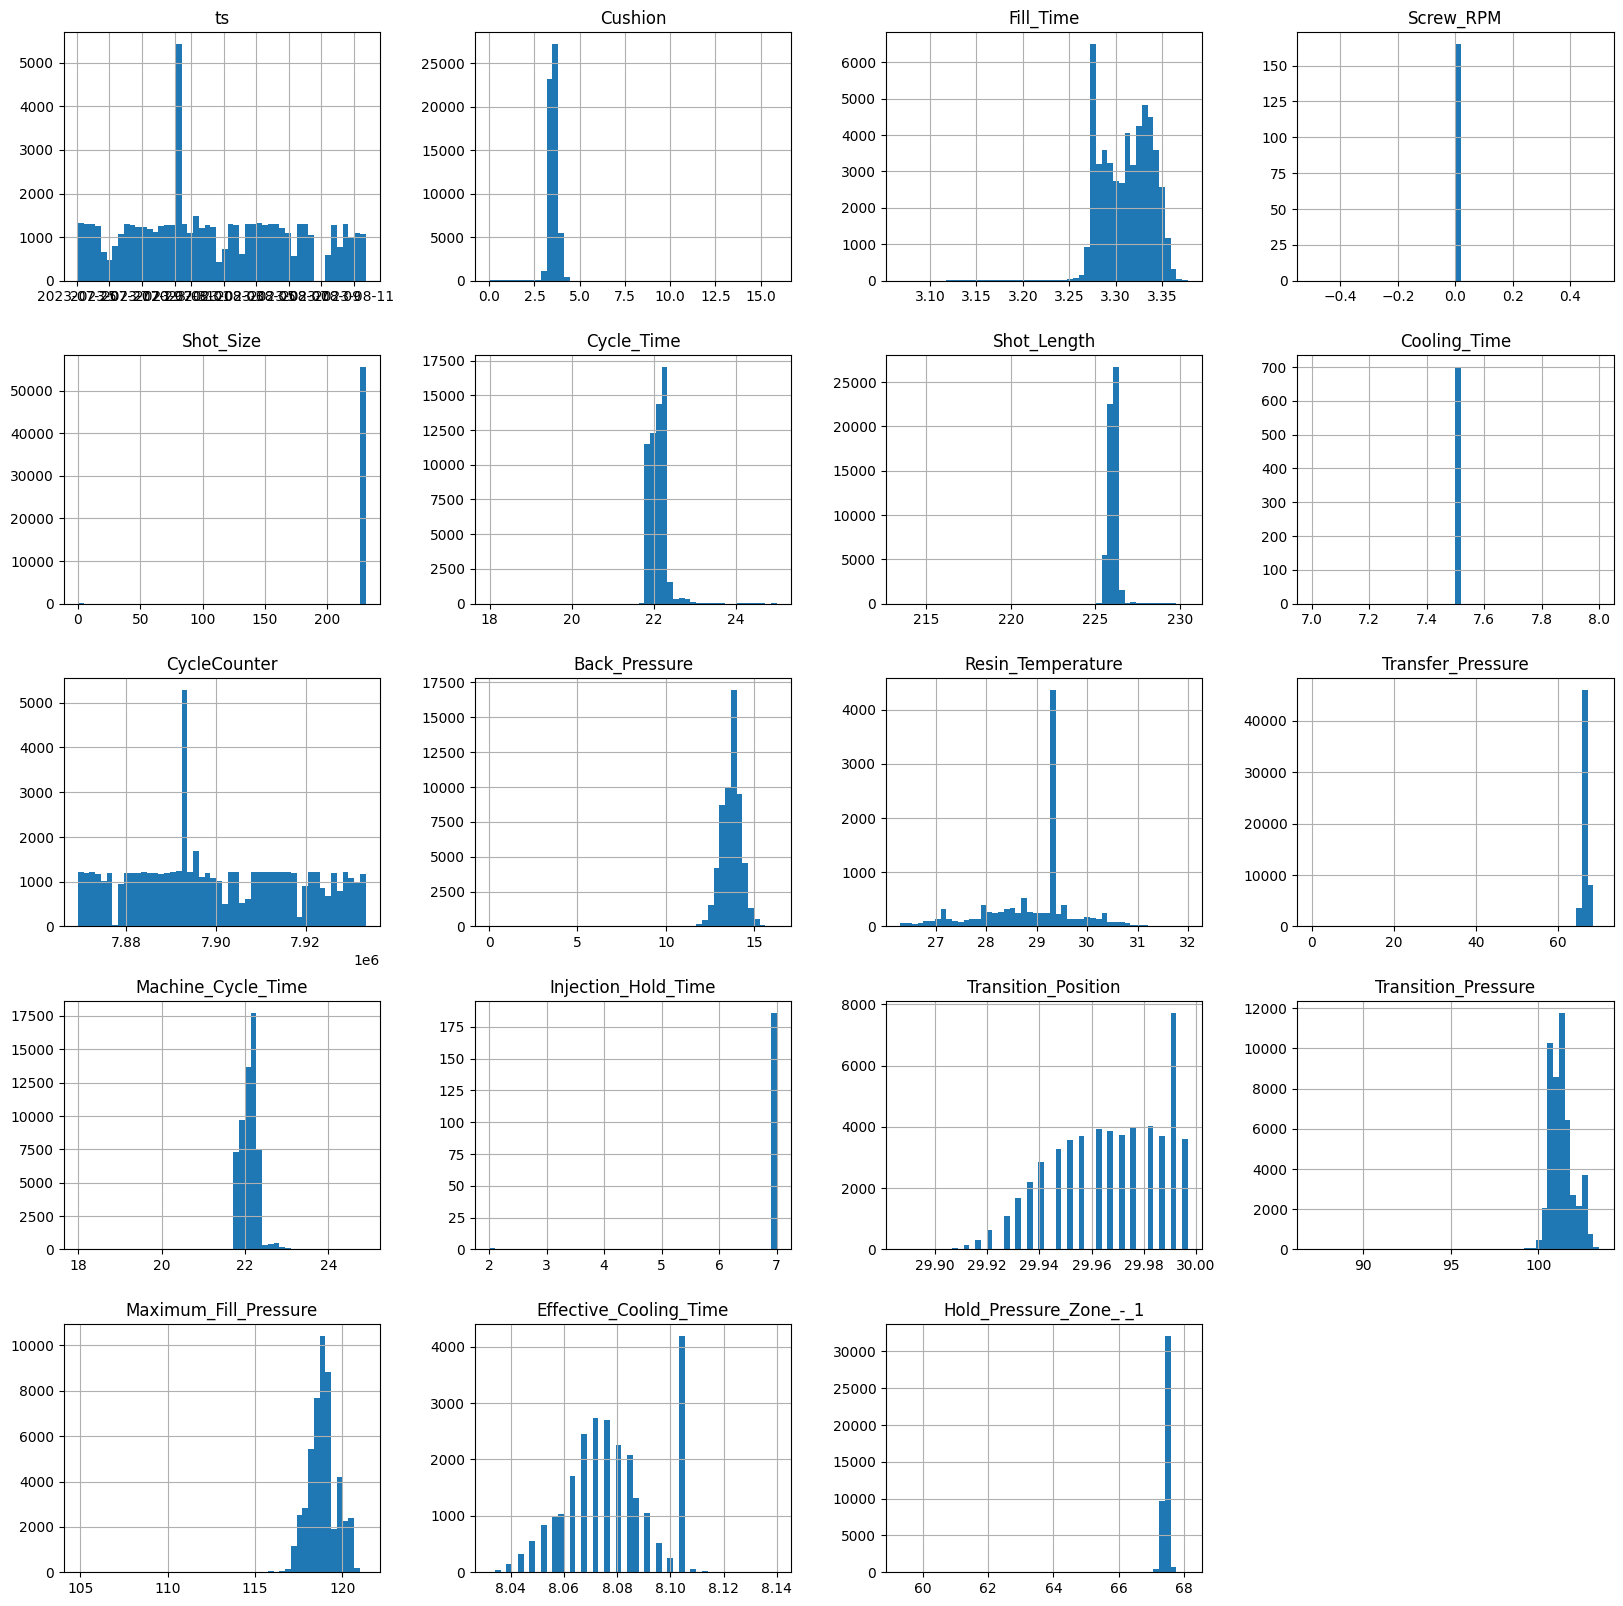

In [4]:
df1=df[df['asset']==maquinas[1]]
df1=df1.drop(['asset',"user_ts", "location"],axis=1)
cols1=df1.variable.unique()
df1c={}
df1m=[]
df1v=[]
cols2=[]
for col in cols1:
    df1c[col]=df1[df1.variable==col].sort_values(by=['ts'])
    df1v.append(df1c[col]["message"].isna().sum()>0)
    df1m.append(df1c[col]["value"].isna().sum()>0)
    if df1c[col]["message"].isna().sum()>0:
        df1c[col]=df1c[col].drop(columns=["message"])
        #rename column value to variable
        df1c[col]=df1c[col].rename(columns={"value": col})
        cols2.append(col)
    
    df1c[col]=df1c[col].drop(columns=["variable"])
df1c[cols1[0]].sort_values(by=['ts'])
for i in range(len(df1v)):
    if df1v[i]==df1m[i]:
        print(cols1[i])
cols1=cols2
df_final=df1c[cols1[0]]
cols1=cols1[1:]
for col in cols1:
    df_final=pd.merge(df_final,df1c[col],how="outer",on="ts")
df_final.sort_values(by=["ts"],inplace=True)
#drop row with Cycle_Time > 25
df_final=df_final[df_final["Cycle_Time"]<25]
df_final=df_final[df_final["Cushion"]<17]
df_final.hist(figsize=(20,20),bins=50);

In [22]:
df_final.describe()

,Cushion,Shot_Size,Cycle_Time,Shot_Length,Back_Pressure,Resin_Temperature,Transfer_Pressure,Transition_Position,Transition_Pressure,Maximum_Fill_Pressure,Hold_Pressure_Zone_-_1
count,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000,58127.000000
mean,3.526573,219.505079,22.103873,221.290293,13.686359,5.880522,66.482949,27.893222,86.476913,103.493705,49.809842
std,0.316329,47.057294,0.203132,32.511192,0.763089,11.648703,3.822043,7.606140,35.765125,39.825720,29.638654
min,0.000000,0.000000,17.988001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.386899,229.566895,21.968000,225.944992,13.330461,0.000000,66.291496,29.946899,100.650284,117.919868,0.000000
50%,3.531899,229.591888,22.104000,226.054993,13.783956,0.000000,66.689575,29.966898,101.138466,118.713173,67.445984
75%,3.641899,229.611893,22.232000,226.199997,14.044338,0.000000,67.009163,29.986898,101.504608,119.262383,67.507004
max,15.886899,230.506897,24.997459,230.474991,16.283806,32.000000,70.133118,29.996899,103.457352,121.337181,68.117241


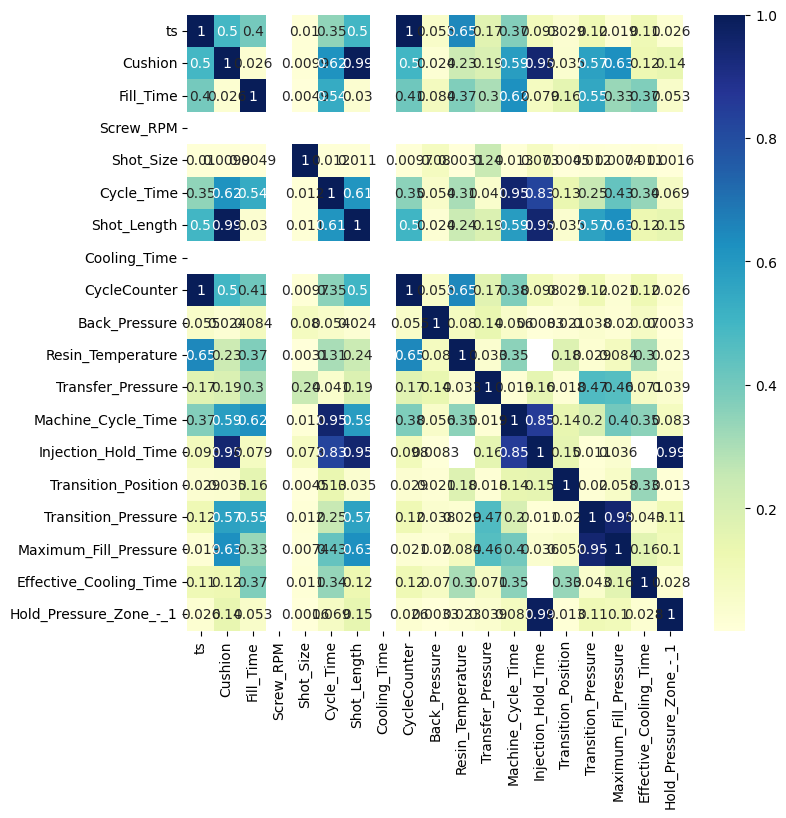

In [5]:
dff1=df_final.copy()
corr_matrix=df_final.corr(numeric_only=False).abs()
plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")
plt.show()

In [6]:
df_final=dff1.copy()
df_final=df_final.fillna(0)
df_final=df_final.drop(columns=["ts","Fill_Time","Effective_Cooling_Time","Injection_Hold_Time",
                                "Screw_RPM","Cooling_Time","CycleCounter","Machine_Cycle_Time"])
df_final.reset_index(drop=True,inplace=True)

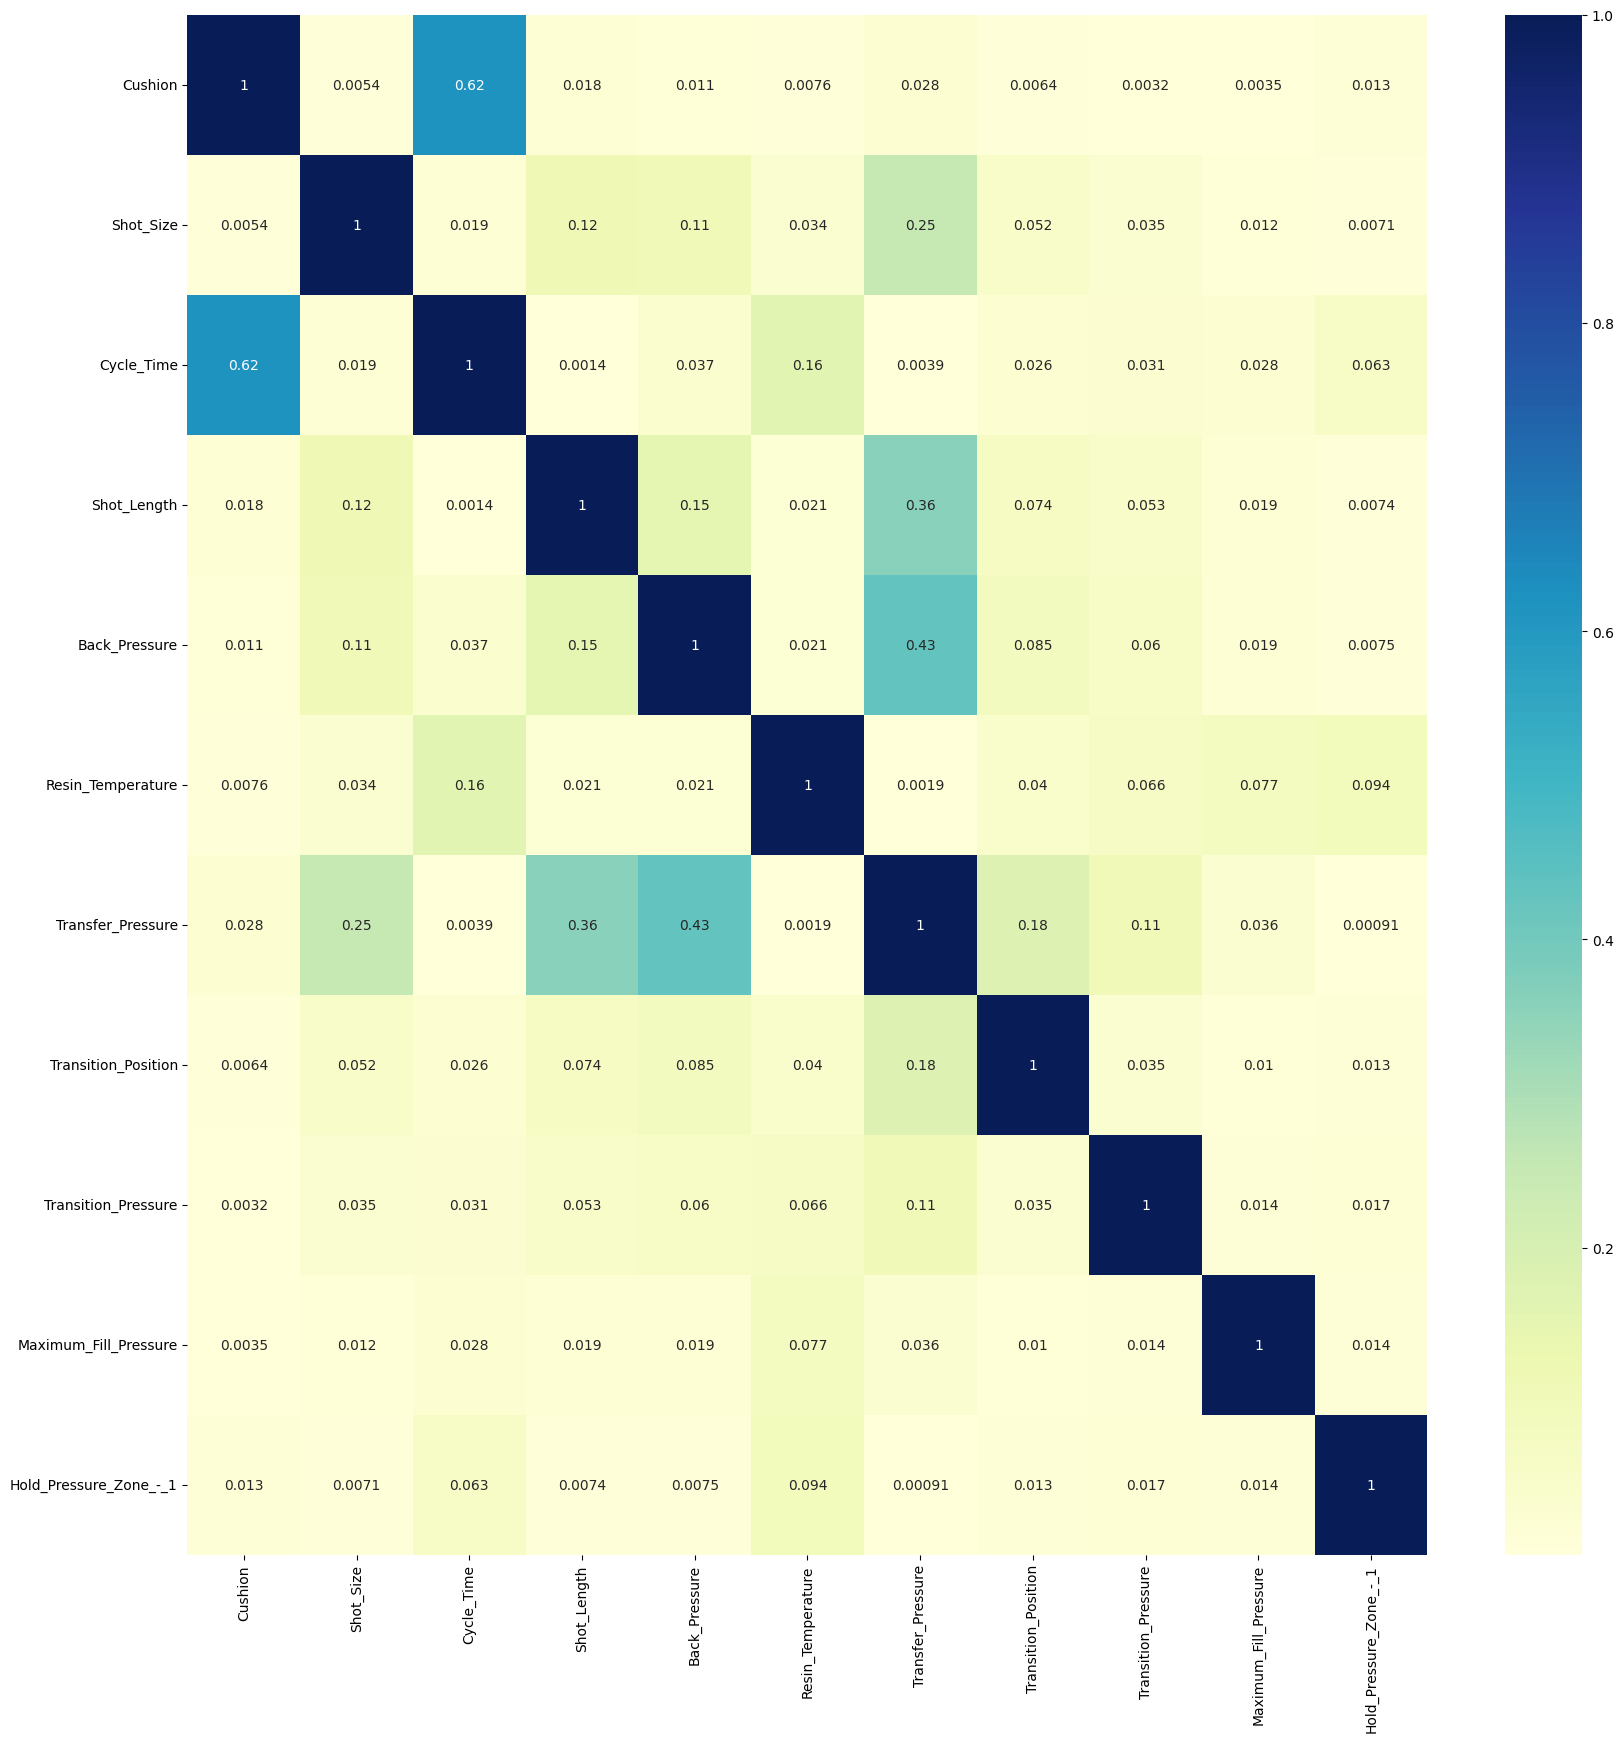

In [7]:
#correlation matrix
corr_matrix=df_final.corr(numeric_only=True).abs()
plt.figure(figsize=(20,20))
sns.heatmap(corr_matrix,annot=True,cmap="YlGnBu")
plt.show()

In [8]:
#forward propagation to select variables
#correlation with Cycle_Time
corr_matrix=df_final.corr(numeric_only=True).abs()

#select variables with correlation > 0.5
corr_matrix=corr_matrix["Cycle_Time"]
corr_matrix=corr_matrix.to_dict()
#drop Cycle_Time to dict
corr_matrix.pop("Cycle_Time")
#sort dict
corr_matrix=sorted(corr_matrix.items(), key=lambda x: x[1],reverse=True)
corr_matrix


[('Cushion', 0.6192570277435356),
 ('Resin_Temperature', 0.16184287393905133),
 ('Hold_Pressure_Zone_-_1', 0.06261909372560587),
 ('Back_Pressure', 0.037064390418689995),
 ('Transition_Pressure', 0.031349031018019065),
 ('Maximum_Fill_Pressure', 0.027759398075040805),
 ('Transition_Position', 0.02561894267424304),
 ('Shot_Size', 0.018880985987685034),
 ('Transfer_Pressure', 0.0038545713949457655),
 ('Shot_Length', 0.001389455828677136)]

In [9]:
variables=[]
for tup in corr_matrix:
    variables.append(tup[0])
    print(tup[0]+": ",tup[1])
    #split data
    X=df_final[variables]
    y=df_final["Cycle_Time"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    #pipeline
    #scalers

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if len(variables)>=2:
        #pca
        pca = PCA(n_components=2)
        pca.fit(X_train_scaled)
        X_train_pca = pca.transform(X_train_scaled)

        #model
        model = LinearRegression()
        model.fit(X_train_pca, y_train)

        # test
        X_test_scaled = scaler.transform(X_test)
        X_test_pca = pca.transform(X_test_scaled)
        y_pred = model.predict(X_test_pca)
        print("PCA: \nMAE:",mean_absolute_error(y_test, y_pred))
        print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
        print("R2:",r2_score(y_test, y_pred))

        #cross validation
        scores = cross_val_score(model, X_train_pca, y_train, cv=5)
        print("Cross-validation scores: {}".format(scores))
        print("Average cross-validation score: {:.2f}".format(scores.mean()))

    #model normal
    model = LinearRegression()
    model.fit(X_train, y_train)

    #test normal
    y_pred = model.predict(X_test)
    print("NORMAL:\nMAE:",mean_absolute_error(y_test, y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2:",r2_score(y_test, y_pred))

    #cross validation normal
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validation scores: {}".format(scores))
    print("Average cross-validation score: {:.2f}".format(scores.mean()))

    #model normal standardize
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    #test normal standardize
    y_pred = model.predict(X_test_scaled)
    print("NORMAL STANDARDIZE:\nMAE:",mean_absolute_error(y_test, y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2:",r2_score(y_test, y_pred))

    #cross validation normal standardize
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print("Cross-validation scores: {}".format(scores))
    print("Average cross-validation score: {:.2f}".format(scores.mean()))

    from sklearn.ensemble import RandomForestRegressor
    regr = RandomForestRegressor(max_depth=3, random_state=42)
    regr.fit(X_train_scaled, y_train)
    y_pred = regr.predict(X_test_scaled)
    print("RFR:\nMAE:",mean_absolute_error(y_test, y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R2:",r2_score(y_test, y_pred))

Cushion:  0.6192570277435356
NORMAL:
MAE: 0.11569692041748252
RMSE: 0.15925199744402374
R2: 0.3503060482960517
Cross-validation scores: [0.40291163 0.40887023 0.39388548 0.37268338 0.37646581]
Average cross-validation score: 0.39
NORMAL STANDARDIZE:
MAE: 0.11569692041748243
RMSE: 0.15925199744402366
R2: 0.35030604829605216
Cross-validation scores: [0.40291163 0.40887023 0.39388548 0.37268338 0.37646581]
Average cross-validation score: 0.39
RFR:
MAE: 0.10596198421302234
RMSE: 0.146615329972925
R2: 0.449321892125253
Resin_Temperature:  0.16184287393905133
PCA: 
MAE: 0.11241834820996646
RMSE: 0.15594928015407217
R2: 0.3769745376969308
Cross-validation scores: [0.43194218 0.43092617 0.42002002 0.40982587 0.40215498]
Average cross-validation score: 0.42
NORMAL:
MAE: 0.11241834820996656
RMSE: 0.15594928015407225
R2: 0.37697453769693
Cross-validation scores: [0.43194218 0.43092617 0.42002002 0.40982587 0.40215498]
Average cross-validation score: 0.42
NORMAL STANDARDIZE:
MAE: 0.112418348209966

In [10]:
#split data
X=df_final.drop(columns=["Cycle_Time"])
y=df_final["Cycle_Time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#pipeline
#scalers

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#pca
pca = PCA(n_components=3)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)

#model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# test
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred = model.predict(X_test_pca)
print("PCA: \nMAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",r2_score(y_test, y_pred))

#cross validation
scores = cross_val_score(model, X_train_pca, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

#model normal
model = LinearRegression()
model.fit(X_train, y_train)

#test normal
y_pred = model.predict(X_test)
print("NORMAL:\nMAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",r2_score(y_test, y_pred))

#cross validation normal
scores = cross_val_score(model, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

#model normal standardize
model = LinearRegression()
model.fit(X_train_scaled, y_train)

from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=3, random_state=42)
regr.fit(X_train_scaled, y_train)
y_pred = regr.predict(X_test_scaled)
print("RFR:\nMAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",r2_score(y_test, y_pred))


regr = RandomForestRegressor(max_depth=3, random_state=42)
regr.fit(X_train_pca, y_train)
y_pred = regr.predict(X_test_pca)
print("RFR PCA:\nMAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",r2_score(y_test, y_pred))



PCA: 
MAE: 0.12438325842368157
RMSE: 0.1678795767862471
R2: 0.2780040213407021
Cross-validation scores: [0.33518998 0.34223796 0.31636218 0.31477967 0.31249699]
Average cross-validation score: 0.32
NORMAL:
MAE: 0.11192754423033768
RMSE: 0.15549926346233203
R2: 0.3805650297867843
Cross-validation scores: [0.43636032 0.43500864 0.42466998 0.41364954 0.40659146]
Average cross-validation score: 0.42
RFR:
MAE: 0.095098711505737
RMSE: 0.136667077443855
R2: 0.5215166148483159
RFR PCA:
MAE: 0.11027995795371397
RMSE: 0.15614706656546978
R2: 0.37539320160584655


In [11]:
import statsmodels.api as sm
X=df_final[variables[0:2]]
y=df_final["Cycle_Time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

regressor_OLS = sm.OLS(endog = y_train, exog = X_train_scaled).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cycle_Time   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                 1.678e+04
Date:                Thu, 07 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:57:25   Log-Likelihood:                 20458.
No. Observations:               46501   AIC:                        -4.091e+04
Df Residuals:                   46498   BIC:                        -4.088e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1042      0.001   3.06e+04      0.000      22.103      22.106
x1            -0.1282      0.001   -177.329      0.000      -0.130      -0.127
x2            -0.0342      0.001    -47.336      0.000      -0.036      -0.033
==============================================================================
Omnibus:                    20262.038   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           627074.247
Skew:                           1.481   Prob(JB):                         0.00
Kurtosis:                      20.745   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

NORMAL STANDARDIZE:
MAE: 0.11241834820996664
RMSE: 0.15594928015407222
R2: 0.37697453769693023
Cross-validation scores: [0.43194218 0.43092617 0.42002002 0.40982587 0.40215498]
Average cross-validation score: 0.42


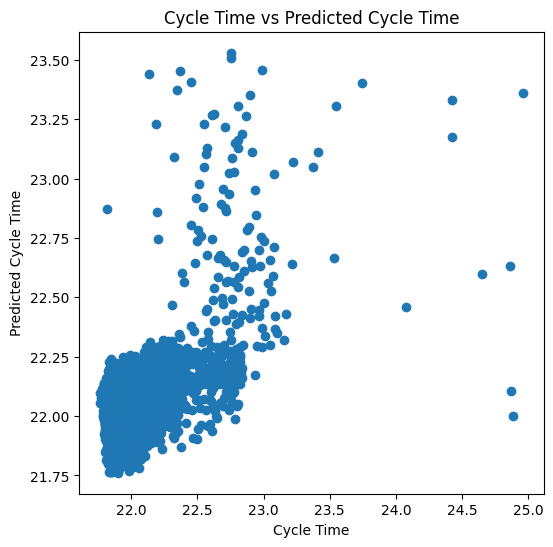

In [12]:
X=df_final[variables[0:2]]
y=df_final["Cycle_Time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scalers
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#model normal standardize
model = LinearRegression()
model.fit(X_train_scaled, y_train)

#test normal standardize
y_pred = model.predict(X_test_scaled)
print("NORMAL STANDARDIZE:\nMAE:",mean_absolute_error(y_test, y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:",r2_score(y_test, y_pred))

#cross validation normal standardize
scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

#plot error vs cycle time
plt.figure(figsize=(6,6))
plt.scatter(y_test,y_pred)
plt.xlabel("Cycle Time")
plt.ylabel("Predicted Cycle Time")
plt.title("Cycle Time vs Predicted Cycle Time")
plt.show()

In [27]:
# prediction with cushion = 3
X=df_final[variables[0:2]]
y=df_final["Cycle_Time"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

#test normal
y_pred = model.predict(X_test)

#predict with cushion = 3 and temperature = 20
# X_test.head()
ynew=X_test.iloc[0,:].copy()
ynew
ynew["Cushion"]=6
ynew["Resin_Temperature"]=30
ynew=model.predict([ynew])
print("Predicted Cycle Time with cushion = 3: ",ynew)

Predicted Cycle Time with cushion = 3:  [21.04513691]


c:\Users\Alfredo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [28]:
#values of regresion
print(model.coef_, model.intercept_)

[-0.39953309 -0.00293332] 23.530335082383264
